<a href="https://colab.research.google.com/github/bluepeach1121/CNN_Model_MNIST/blob/main/Pneunomia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import os
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
#downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:28<00:00, 198MB/s]
100% 2.29G/2.29G [00:28<00:00, 85.2MB/s]


In [ ]:
import zipfile
from pathlib import Path as path

#setup path to the dataset folder
image_path = path('dataset')

#if the dataset folder doesnt exist, create it
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping creation')
else:
    print(f'{image_path} doesnt exist, creating one..')
    image_path.mkdir(parents=True, exist_ok=True)

#unzip xray dataset
zip_file_path = path('chest-xray-pneumonia.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    print('unzippin xray dataset..')
    zip_ref.extractall(image_path)

print('done')


dataset doesnt exist, creating one..
unzippin xray dataset..
done


In [ ]:
import shutil
macosx_folder = image_path / 'chest_xray' / '__MACOSX'
chest_xray_folder = image_path / 'chest_xray' / 'chest_xray'

# Delete the _MACOSX folder if it exists
if macosx_folder.is_dir():
    print(f'Deleting {macosx_folder}...')
    shutil.rmtree(macosx_folder)

# Delete the chest_xray folder if it exists
if chest_xray_folder.is_dir():
    print(f'Deleting {chest_xray_folder}...')
    shutil.rmtree(chest_xray_folder)

print('Done.')

Deleting dataset/chest_xray/__MACOSX...
Deleting dataset/chest_xray/chest_xray...
Done.


In [ ]:
def walk_through_dir(dir_path):
    """ walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
walk_through_dir(image_path)

there are 1 directories and 0 images in dataset
there are 3 directories and 0 images in dataset/chest_xray
there are 2 directories and 0 images in dataset/chest_xray/val
there are 0 directories and 8 images in dataset/chest_xray/val/PNEUMONIA
there are 0 directories and 8 images in dataset/chest_xray/val/NORMAL
there are 2 directories and 0 images in dataset/chest_xray/test
there are 0 directories and 390 images in dataset/chest_xray/test/PNEUMONIA
there are 0 directories and 234 images in dataset/chest_xray/test/NORMAL
there are 2 directories and 0 images in dataset/chest_xray/train
there are 0 directories and 3875 images in dataset/chest_xray/train/PNEUMONIA
there are 0 directories and 1341 images in dataset/chest_xray/train/NORMAL


In [ ]:
train_dir = image_path / 'chest_xray/train'
test_dir = image_path / 'chest_xray/test'
val_dir = image_path / 'chest_xray/val'

train_dir, test_dir, val_dir

(PosixPath('dataset/chest_xray/train'),
 PosixPath('dataset/chest_xray/test'),
 PosixPath('dataset/chest_xray/val'))

In [ ]:
import random
from PIL import Image

image_path_list = list(image_path.glob('*/*/*/*.jpeg'))
random.sample(image_path_list, 5)

[PosixPath('dataset/chest_xray/train/PNEUMONIA/person93_virus_175.jpeg'),
 PosixPath('dataset/chest_xray/test/PNEUMONIA/person122_bacteria_581.jpeg'),
 PosixPath('dataset/chest_xray/test/PNEUMONIA/person34_virus_76.jpeg'),
 PosixPath('dataset/chest_xray/train/NORMAL/NORMAL2-IM-0904-0001.jpeg'),
 PosixPath('dataset/chest_xray/train/NORMAL/NORMAL2-IM-1043-0001.jpeg')]

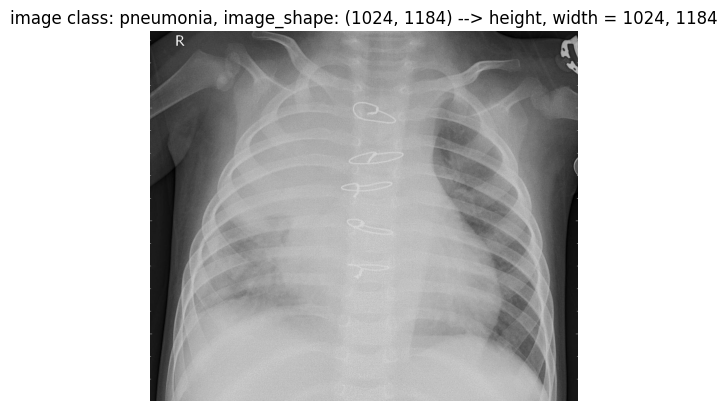

In [ ]:
#1. pick a ramdom image from the image path
random_image_path = random.choice(image_path_list)

#gettin image class
image_class = random_image_path.parent.stem.lower()

#opening image
img = Image.open(random_image_path)
img_array = np.asarray(img, dtype=float)
plt.imshow(img_array, cmap='gray')
plt.title(f'image class: {image_class}, image_shape: {img_array.shape} --> height, width = {img.size[1]}, {img.size[0]}')
plt.axis('off');

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform

        if not self.root_dir.is_dir():
            raise ValueError(f"Provided root dir '{root_dir}' is not a valid directory")

        # Gather all image paths
        self.image_paths = list(self.root_dir.glob('**/*.jpeg'))

        # Check if there are images in the directory
        if not self.image_paths:
            raise ValueError(f"No image found in the provided directory, '{root_dir}'.")

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index
        Returns:
            tuple: (image, label) where label is derived from the file path.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        image = Image.merge("RGB", (image, image, image))  # Convert grayscale to RGB

        # Convert image to numpy array
        image = np.array(image)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Get label from the directory name
        label_name = img_path.parent.stem.lower()
        label = 1 if label_name == 'pneumonia' else 0
        label = torch.tensor(label, dtype=torch.float64)

        return image, label

# Define the Albumentations transformations
transformer = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    A.OneOf([
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1)),
        A.ChannelShuffle(p=0.5),
        A.ToGray(p=0.2)
    ], p=0.2),

    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [ ]:
train_data = CustomDataset(root_dir=train_dir,
                           transform= transformer)

test_data = CustomDataset(root_dir=test_dir,
                           transform= transformer)

val_data = CustomDataset(root_dir=val_dir,
                         transform= transformer)

##how to unnormalize data

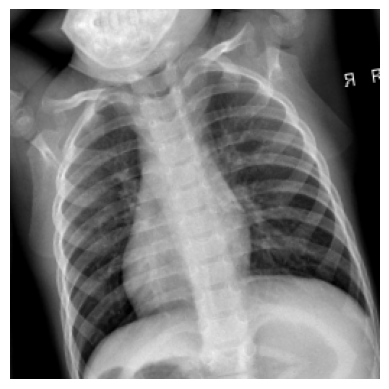

Label: Normal


In [ ]:
import matplotlib.pyplot as plt
import random

def imshow(img):
    # Unnormalize the image
    img = img.numpy().transpose((1, 2, 0))  # Change from CxHxW to HxWxC
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Pick a random index and view the image
random_index = random.randint(0, len(train_data) - 1)
image_tensor, label = train_data[random_index]

imshow(image_tensor)
label_text = 'Pneumonia' if label == 1 else 'Normal'
print(f'Label: {label_text}')


##dataloader

In [ ]:
# turn train and test datasets into dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              shuffle= True,
                              )

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             )

validation_dataloader = DataLoader(dataset=val_data,
                                   batch_size= BATCH_SIZE,
                                   shuffle=False,
                                   )

train_dataloader, test_dataloader, validation_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a3f7d457f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7a3f7d457df0>)

In [ ]:
len(train_dataloader), len(test_dataloader), len(validation_dataloader)

(652, 78, 2)

In [ ]:
img, label =next(iter(train_dataloader))

print(f'image shape: {img.shape} -> [batch_size, color_channels, height, width]')

image shape: torch.Size([8, 3, 256, 256]) -> [batch_size, color_channels, height, width]


#creating my model

In [ ]:
#get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchsummary import summary

# Model configuration
h = {
    "image_size": 256,
    "model": "resnet101",
    "num_classes": 2,
    "learning_rate": 0.0007,
    "batch_size": BATCH_SIZE,
    "num_epochs": 10
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Create the model
def create_model(h, device):
    if h["model"] == "resnet101":
        model = models.resnet101(pretrained=True)

        # Freeze all the parameters
        for param in model.parameters():
            param.requires_grad = False

        # Modify the final fully connected layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, h["num_classes"])

        # Ensure the new fully connected layer is trainable
        for param in model.fc.parameters():
            param.requires_grad = True

        model = model.to(device)
    return model

model = create_model(h, device)


In [ ]:
# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.fc.parameters(), lr=h["learning_rate"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)

# Define loss function
criterion = nn.CrossEntropyLoss()


In [ ]:
# Create a dummy input tensor
dummy_input = torch.randn(h["batch_size"], 3, h["image_size"], h["image_size"]).to(device)

# Pass the dummy tensor through the model
output = model(dummy_input)

# Print the output shape
print(f"Output shape: {output.shape}")

# Display the model summary
summary(model, input_size=(3, h["image_size"], h["image_size"]))


Output shape: torch.Size([8, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """
    Performs a single training step.
    """
    model.train()  # Set the model to training mode
    train_loss, train_acc = 0.0, 0.0

    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device).long()

        # Forward pass
        y_pred = model(X).float()

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    """
    Performs a single validation/test step.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0.0, 0.0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device).long(), y.to(device).long()

            # Forward pass
            y_pred = model(X)

            # Calculate the loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device):
    """
    Trains and tests a PyTorch model.
    """
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        scheduler.step(test_loss)

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [ ]:
%%time
# Train the model
results = train(model= model,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer,
                loss_fn = criterion,
                scheduler = scheduler ,
                epochs=h["num_epochs"],
                device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | train_loss: 0.2969 | train_acc: 0.8702 | test_loss: 0.3455 | test_acc: 0.8558
Epoch 2/10 | train_loss: 0.2268 | train_acc: 0.9039 | test_loss: 0.4805 | test_acc: 0.8237
Epoch 3/10 | train_loss: 0.2188 | train_acc: 0.9143 | test_loss: 0.6043 | test_acc: 0.7933
Epoch 4/10 | train_loss: 0.2112 | train_acc: 0.9172 | test_loss: 0.3539 | test_acc: 0.8782
Epoch 5/10 | train_loss: 0.1997 | train_acc: 0.9245 | test_loss: 0.4749 | test_acc: 0.8413
Epoch 6/10 | train_loss: 0.1797 | train_acc: 0.9250 | test_loss: 0.3607 | test_acc: 0.8734
Epoch 7/10 | train_loss: 0.1960 | train_acc: 0.9239 | test_loss: 0.4419 | test_acc: 0.8622
Epoch 8/10 | train_loss: 0.1592 | train_acc: 0.9362 | test_loss: 0.4001 | test_acc: 0.8766
Epoch 9/10 | train_loss: 0.1637 | train_acc: 0.9387 | test_loss: 0.4828 | test_acc: 0.8478
Epoch 10/10 | train_loss: 0.1687 | train_acc: 0.9327 | test_loss: 0.4988 | test_acc: 0.8574
